This is a practice notebook to try and create a model to identify dog breed according to picture.

This will be based off of lesson1.pynb from the fastai dl1 course (2018)

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# All necessary imports
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [32]:
#PATH is the path to our data
PATH = "data/dogBreeds/"
sz=396
arch=resnext101_64
bs=16

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['train',
 'labels.csv',
 'test',
 'sample_submission.csv.zip',
 'train.zip',
 'test.zip',
 'labels.csv.zip']

In [7]:
files = os.listdir(f'{PATH}train')
files

['37f351d4657a5d7420bb7b146a6672e0.jpg',
 'de93a60e4b3dd5518460dafda4a1c8b5.jpg',
 '8feac68f15de7bf1965b2de4f821ec14.jpg',
 '42a49cd92129a383d959dd3a52bae3f9.jpg',
 'd019f029b4480dfcd04b0fb07249a9aa.jpg',
 '57613fae3f9485c50a2331b4db6582cc.jpg',
 'd96c7a1efc7455d533bb2beb4da27896.jpg',
 '04a3f5dc6d985601f354ab4434645d83.jpg',
 '8bba6c2e3b2994c4e313d2c489e29880.jpg',
 '886c611904fc29caee5f9cd908b90dc4.jpg',
 'cf835d1c4bc696f14bc631156c9a770f.jpg',
 '2d619ed09dfae38b0f73b5b75d1db784.jpg',
 '32a621c751219cd0abf1fef7a1ec7972.jpg',
 'e0032d2cfc32a75f448d9f931f6bca19.jpg',
 'f39409a147cf719a7e34712034b41625.jpg',
 '1f705dd3c8f4c66cb14b706990b80bc5.jpg',
 'ed8bd115216fc760fd0ae45471791f7f.jpg',
 'c3912710a89f0e88320b8fe07578a972.jpg',
 'b3c360cdc204d571b5287268fa4b4c25.jpg',
 '8a5ba5ac735272c8f85b0af39f8d7b29.jpg',
 '4f7acd612879022f09fb7e63eec8bb50.jpg',
 '30668e8d4c74c185ef86f86d9ff158a4.jpg',
 '7cbde2616a11273a406b99a55d18745e.jpg',
 '5aef2850c1ad620dafdeb39745316d81.jpg',
 '7edf7c9919f285

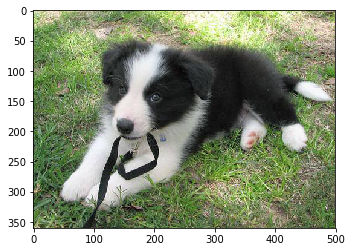

In [8]:
img = plt.imread(f'{PATH}train/{files[8000]}')
plt.imshow(img);

In [9]:
img.shape

(360, 500, 3)

In [10]:
img[:4,:4]

array([[[243, 247, 210],
        [218, 223, 183],
        [204, 206, 166],
        [205, 206, 162]],

       [[222, 229, 188],
        [232, 239, 197],
        [224, 230, 186],
        [189, 192, 147]],

       [[200, 209, 164],
        [231, 240, 195],
        [249, 255, 212],
        [220, 228, 181]],

       [[232, 246, 195],
        [222, 236, 185],
        [225, 237, 187],
        [216, 228, 180]]], dtype=uint8)

In [11]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [12]:
!ls {PATH}
label_df = pd.read_csv(label_csv)

labels.csv	sample_submission.csv.zip  test.zip  train.zip
labels.csv.zip	test			   train


In [13]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id',ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [15]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', 
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [16]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [17]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

In [18]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=4,
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    return data if sz>300 else data.resize(340, 'tmp')

In [33]:
data = get_data(sz,bs)

In [34]:
arch=resnext50
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 648/648 [07:06<00:00,  1.52it/s]


In [39]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.339971   0.368448   0.891389  



[array([0.36845]), 0.8913894324853229]

In [ ]:
from sklearn import metrics

In [ ]:
data = get_data(sz,bs)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [ ]:
learn.fit(.01, 12)

In [40]:
learn.precompute=False

In [41]:
learn.fit(.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.32061    0.33956    0.895303  
  3%|▎         | 15/512 [00:12<06:40,  1.24it/s, loss=0.29] 

KeyboardInterrupt: 

In [ ]:
learn.unfreeze()

In [ ]:
lr=np.array([.00001,.0001,.001])

In [ ]:
learn.fit(lr, 20, cycle_len=1, cycle_mult=2)

In [ ]:
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

Learning rate finder:

In [22]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [35]:
lrf=learn.lr_find()

 78%|███████▊  | 401/512 [00:03<00:00, 111.23it/s, loss=9.29]


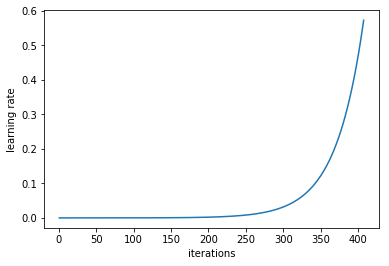

In [36]:
learn.sched.plot_lr()

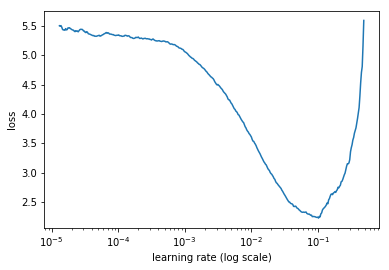

In [37]:
learn.sched.plot()